In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools

In [2]:
max_length = 0
corpus = list()
labels = list()

with open(Path('./output/benign/all_benign.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(0)
  

In [3]:
with open(Path('./output/malware/all_malware.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(1)

In [4]:
labels = np.array(labels)

In [5]:
print(len(max(corpus)))

557579


In [6]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=512000)
print(X.shape)

(2800, 512000)


In [15]:
X = X.reshape(-1, 64, 8000)
print(X.shape)

(2800, 256, 2000)


In [16]:
vocab_size = len(tokenizer.word_index) + 1
print(f'노드 개수: {vocab_size}, 한 개 밖에 없는 노드:', end=' ')
unique_word = 0
for k in tokenizer.word_docs:
  if tokenizer.word_docs[k] == 1:
    unique_word += 1
print(unique_word)

노드 개수: 26, 한 개 밖에 없는 노드: 0


In [22]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.SimpleRNN(256, input_shape = (64, 8000)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 256)               577792    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 586,049
Trainable params: 586,049
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)
print(f'Train을 {X_train.shape}만큼, Test를 {X_test.shape}만큼 진행')

Train을 (2520, 256, 2000)만큼, Test를 (280, 256, 2000)만큼 진행


In [ ]:
import tensorflow_addons as tfa
import tqdm

tqdm_callback = tfa.callbacks.TQDMProgressBar()


batch_size = 256
mc = ModelCheckpoint('./log/Simple_RNN_dense2.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size,
                    verbose=0, validation_data=(X_test, y_test), callbacks=[mc, tqdm_callback])


In [20]:
model.load_weights('./log/Simple_RNN_model_shape(256).h5')

In [21]:
y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
y_pred = [y >= 0.5 for y in y_pred]

print(metrics.classification_report(y_test, y_pred, digits=3))
with open('log/report.txt', 'w') as f:
  f.write(str(metrics.classification_report(y_test, y_pred, digits=3)))


2/2 [==============================] - 1s 50ms/step
              precision    recall  f1-score   support

           0      0.835     0.886     0.860       149
           1      0.861     0.802     0.830       131

    accuracy                          0.846       280
   macro avg      0.848     0.844     0.845       280
weighted avg      0.847     0.846     0.846       280



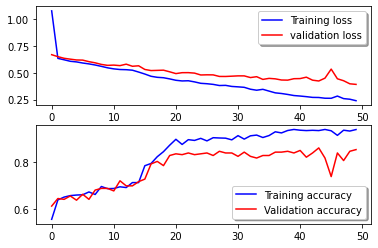

In [14]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)